# Import and deal with hard data files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import os
import sys
import pyvista as pv
pv.set_jupyter_backend('static')
import pandas as pd

try:
    import ArchPy
except: # if ArchPy is not installed
    print("ArchPy not installed")
    sys.path.append("../..")
    import ArchPy

ArchPy not installed


## Introduction

This notebook present how to load and import hard data files (boreholes) with ArchPy.

For this ArchPy requires three different data files which are text files. A list of borholes, a list of unit data and a list of facies data.

They can have any extensions but the recommended are :

list of boreholes  -> ``.lbh``

list of unit data  -> ``.ud``

list of facies data  -> ``.fd``

For this example, the files are in the 2_data_folder.

We can detail these files :
- ``.lbh`` : text file with five columns listing all the boreholes in the data. It has five columns and default headers are :
    - bh_ID : borehole identifier to know at which borehole a unit/facies data belongs
    - bh_x : x borehole coordinate
    - bh_y : y borehole coordinate
    - bh_z : z borehole coordinate
    - bh_depth : borehole depth
    
    
- ``.ud`` : text file with four columns listing all the stratigraphical unit interval data. Default headers are :
    - bh_ID : borehole identifier to know at whcih borehole the unit data belongs
    - Strat : Unit identifier to know at which unit this unit interval data belongs
    - top   : top elevation of the interval
    - bot   : bot elevation of the interval
    
    
- ``.fd`` : text file with four columns listing all the facies interval data. Default headers are :
    - bh_ID : borehole identifier to know at whcih borehole the unit data belongs
    - facies_ID : facies identifier to know at which facies this facies interval data belongs
    - top   : top elevation of the interval
    - bot   : bot elevation of the interval


In [2]:
#path to the files
folder = "2_data_folder"
l_bh_path = pd.read_csv(os.path.join(folder, "IO_exemple.lbh"))

unit_data_path = pd.read_csv(os.path.join(folder, "IO_exemple.ud"))

facies_data_path = pd.read_csv(os.path.join(folder, "IO_exemple.fd"))


## First step : import

### We can now import the geological database with the function : ``ArchPy.inputs.load_bh_files``

This function takes the dataframe of the 3 inputs files as arguments but also column names if they are differents (e.g. bh_id_col which is by default "bh_ID" or u_top_col which is the name of the column indicating top elevation in .ud file).

Dictionnaries can also be passed (``dic_units_names`` and ``dic_facies_names``) which will change units/facies names in database with associated values in dictionnary. For example, if a ``dic_units_names = {"Lias" : "Jura",  "Dogger" : "Jura", "Malm" : "Jurassic"}`` is passed, all unit names in keys will be replaced by "Jurassic". This can be useful to merge some facies or units if they are similar.

Last parameter is ``altitude`` flag which indicates to ArchPy if elevation values in database are in altitude or not (depth if False).

It returns two dataframes : the geological database (db) and the list of boreholes with columns properly renamed to be used in ``extract_bhs function``.

In [3]:
#import data
db, l_bhs = ArchPy.inputs.load_bh_files(list_bhs=l_bh_path, 
                            units_data=unit_data_path,
                            facies_data=facies_data_path, altitude=True)
db #print database

,Strat_ID,Facies_ID,top,bot
bh_ID,,,,
bh1,B,Clay,15.0,10.0
bh1,B,Sand,10.0,8.0
bh1,B,Clay,8.0,5.0
bh1,A,Silt,5.0,2.0
bh1,A,Gravel,2.0,-1.0
bh1,A,Sand,-1.0,-5.0
bh2,C,Gravel,15.0,10.0
bh2,B,Sand,10.0,8.0
bh2,B,Clay,8.0,4.0


The database has been imported but no project has been defined. We need to create one that respects the Hard data present here.

## Second step

Creating the Project with appropriated units/facies.

For simplicity SIS will be used to fill these units.

In [4]:
T1 = ArchPy.base.Arch_table(name = "ex2", working_directory="2_data_folder", seed = 10, verbose = 1)

In [5]:
nx = 150 #number of cells in x
ny = 150 
nz = 50
sx = 0.2 #cell width in x
sy = 0.2
sz = 0.5
ox = 0 # x coordinates of the origin
oy = 0
oz = -10
dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (ox, oy, oz)

T1.add_grid(dimensions, spacing, origin) #adding the grid

## Adding Grid ##
## Grid added and is now simulation grid ##


In [6]:
P1 = ArchPy.base.Pile("Pile_1")
T1.set_Pile_master(P1)

Pile sets as Pile master


## Units

In [7]:
##C
#Creation of the top unit C
covmodel_SIS = gcm.CovModel3D(elem = [("spherical", {"w":2, "r": [20,20,10]}),
                                      ("exponential", {"w":1, "r": [30,30,10]})])

dic_facies_c = {"f_method" : "homogenous", #filling method
                 "f_covmodel" : covmodel_SIS, #SIS covmodels
                } #dictionnary for the unit filling

C = ArchPy.base.Unit(name = "C",
                      order = 1,       #order in pile
                      color = "lightgreen",  
                      surface=ArchPy.base.Surface(),  # top surface
                      ID = 1,
                      dic_facies=dic_facies_c
                     ) 


## B
#surface B
covmodel_b = gcm.CovModel2D(elem = [("cubic", {"w":2, "r" : [15,5]})])
dic_surf_b = {"covmodel" : covmodel_b, "int_method" : "grf_ineq"}
Sb = ArchPy.base.Surface(name = "Sb", dic_surf=dic_surf_b)

#dic facies b 
dic_facies_b = {"f_method" : "SIS", "f_covmodel" : covmodel_SIS, "probability" : [0.7, 0.3]} 

B = ArchPy.base.Unit(name = "B",
                      order = 2,   #order in pile
                      color = "greenyellow", #color
                      surface=Sb, # top surface
                      ID = 2,     #ID
                      dic_facies=dic_facies_b #facies dictionnary
                     )


##A
covmodel_a = gcm.CovModel2D(elem = [("spherical", {"w":1, "r" : [5,5]})])
dic_surf_a = {"covmodel" : covmodel_b, "int_method" : "grf_ineq"}
Sa = ArchPy.base.Surface(name = "Sa", dic_surf=dic_surf_a)

#dic facies a
dic_facies_a = {"f_method" : "SIS", "f_covmodel" : covmodel_SIS} 

A = ArchPy.base.Unit(name = "A",
                      order = 3,   #order in pile
                      color = "lightcoral", #color
                      surface=Sa, # top surface
                      ID = 3,     #ID
                      dic_facies=dic_facies_a #facies dictionnary
                     )

#Adding the units to the Pile
P1.add_unit([C, B, A])

Unit C: Surface added for interpolation
Unit B: covmodel for SIS added
Unit B: Surface added for interpolation
Unit A: covmodel for SIS added
Unit A: Surface added for interpolation
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


## Facies

In [8]:
Sand = ArchPy.base.Facies(ID = 1, name = "Sand", color = "yellow")
Clay = ArchPy.base.Facies(ID = 2, name = "Clay", color = "royalblue")
Gravel = ArchPy.base.Facies(ID = 3, name = "Gravel", color = "palegreen")
Silt = ArchPy.base.Facies(ID = 4, name = "Silt", color = "goldenrod")


C.add_facies(Gravel)
B.add_facies([Clay, Sand])
A.add_facies([Sand, Gravel, Silt])

Facies Gravel added to unit C
Facies Clay added to unit B
Facies Sand added to unit B
Facies Sand added to unit A
Facies Gravel added to unit A
Facies Silt added to unit A


## Extract boreholes from database

We can now extract boreholes objects with ``ArchPy.inputs.extract_bhs``.
Note : This function requires the list of boreholes path

In [9]:
boreholes = ArchPy.inputs.extract_bhs(df=db, list_bhs=l_bhs, ArchTable=T1)

## Borehole class

In ArchPy, the geological data are in "borehole" format. Here we have created boreholes directly from a database but they can also be create manually in python with ``ArchPy.base.borehole``.

A borehole takes multiple arguments : 
- name
- ID
- x,y,z : top borehole coordinates 
- depth : depth of the borehole
- log_strati : unit data which is a list of tuple, each tuple containing a unit object and an elevation 
(e.g. ``log_strati = [(D, 10), (C, 6), ...]``).
- log_facies : facies data, identical to log_strati except unit object are facies object

They are added to the project with ``add_bh``.

In [10]:
T1.add_bh(boreholes)

Borehole bh1 added
Borehole bh2 added
Borehole bh3 added


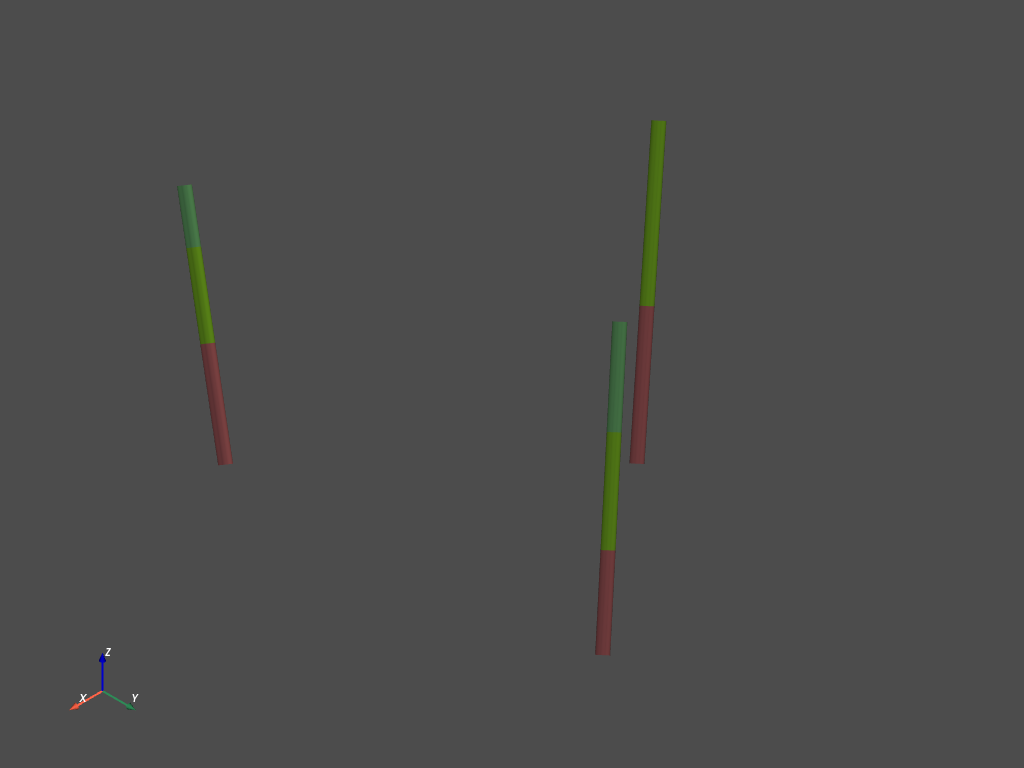

In [11]:
#We can look at what the boreholes looks with plot_bhs()
p=pv.Plotter()
T1.plot_bhs(plotter=p)
p.show_axes()
p.show()

### It is now important to process the data in order to get the HD correctly

All this step is automated by calling process_bhs

In [12]:
T1.process_bhs()

##### ORDERING UNITS ##### 
Pile Pile_1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set
Processing ended successfully


### Check

We can check that Hard Data have been extracted. They are stored inside surface objects directly.
Here with B top surface that have 2 equality point and 1 inequality point (lower boundary)

In [13]:
unit = B

for ix,iy,iz in zip(unit.surface.x,unit.surface.y,unit.surface.z):
    print("equality point : {} x, {} y, {} z".format(ix,iy,iz))

for ineq in unit.surface.ineq:
    print("inequality point : {} x, {} y, {} vmin, {} vmax".format(ineq[0], ineq[1], ineq[3], ineq[4]))

equality point : 15 x, 25 y, 10.0 z
equality point : 20 x, 5 y, 12.0 z
inequality point : 1 x, 15 y, 15.0 vmin, nan vmax


## Simulations

In [14]:
T1.compute_surf(1)

########## PILE Pile_1 ##########
Pile Pile_1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
Unit A has no inequality point, the interpolation method is switched to GRF
A: time elapsed for computing surface 0.01401209831237793 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.022020339965820312 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.07606935501098633 s
##########################


### 0.1261153221130371: Total time elapsed for computing surfaces ###


In [15]:
T1.compute_facies(1)


### Unit C: facies simulation with homogenous method ####
### Unit C - realization 0 ###
Time elapsed 0.01 s

### Unit B: facies simulation with SIS method ####
### Unit B - realization 0 ###
Only one facies covmodels for multiples facies, adapt sill to right proportions
Time elapsed 2.39 s

### Unit A: facies simulation with SIS method ####
### Unit A - realization 0 ###
Only one facies covmodels for multiples facies, adapt sill to right proportions
Time elapsed 4.5 s

### 6.91: Total time elapsed for computing facies ###


C:\Users\emmal\Anaconda3\envs\LS\lib\site-packages\pyvista\core\dataset.py:1335: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  PyvistaDeprecationWarning


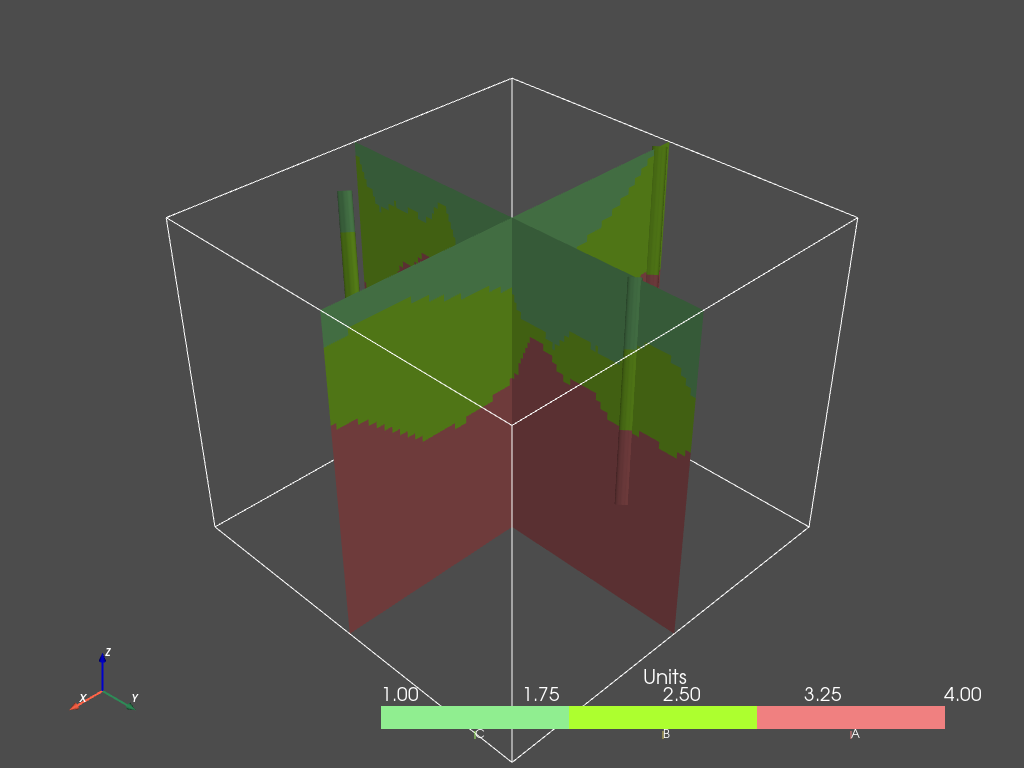

In [16]:
p = pv.Plotter()

v_ex = 1
T1.plot_units(plotter=p, slicex=(0.5), slicey=(0.5),v_ex=v_ex)
T1.plot_bhs(plotter=p, v_ex=v_ex)
p.show()

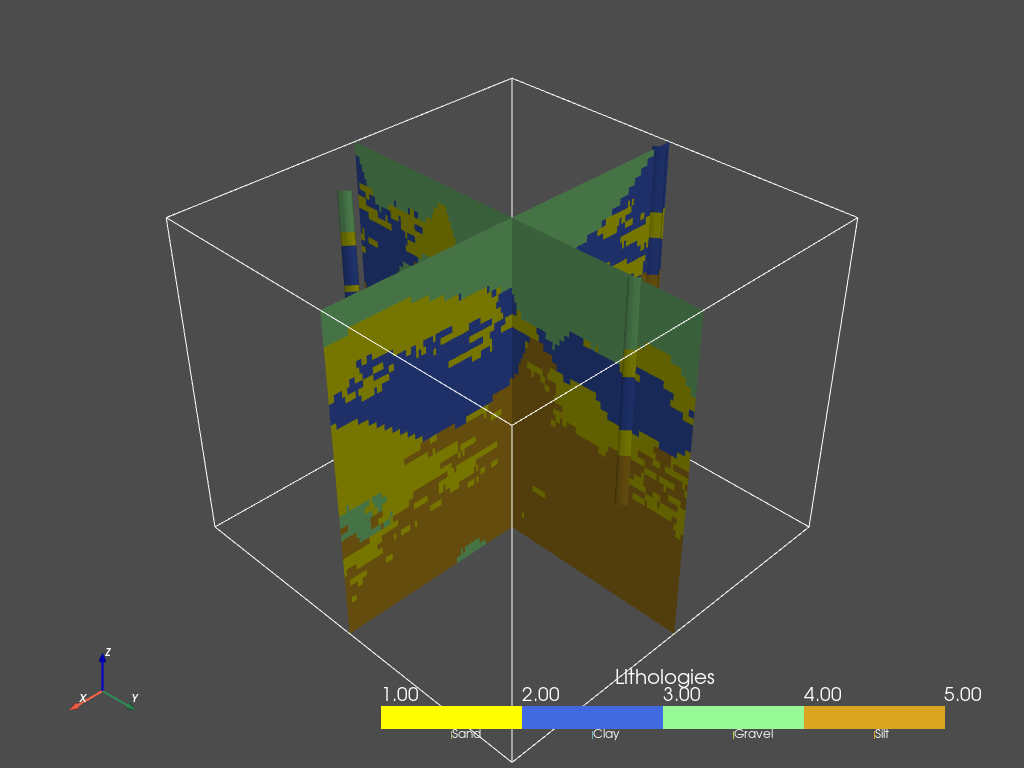

In [17]:
p = pv.Plotter()
T1.plot_facies(plotter=p, slicex=(0.5), slicey=(0.5),v_ex=1)
T1.plot_bhs("facies", plotter=p, v_ex=1)
p.show()

This concludes this little tutorial on ArchPy inputs capabilities